In [1]:
import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url = HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
import matplotlib.pyplot as plt
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label ="population", figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [4]:
corr_matrix = housing.corr()

In [5]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1197cd240>,
      dtype=object)

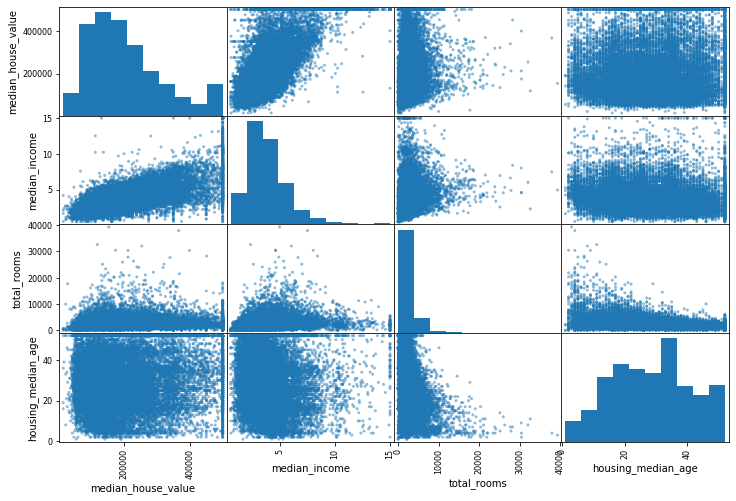

In [6]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

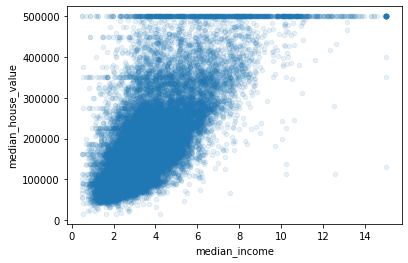

In [7]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [8]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

import numpy as np

housing.info()
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing= strat_train_set.drop("median_house_value", axis=1)
housing_labels= strat_train_set["median_house_value"].copy()
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)


housing_cat = housing[['ocean_proximity']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20433 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
ocean_proximity             20640 non-null object
rooms_per_household         20640 non-null float64
bedrooms_per_room           20433 non-null float64
population_per_household    20640 non-null float64
dtypes: float64(12), object(1)
memory usage: 2.0+ MB


In [10]:
# from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])


cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

cat_pipeline = Pipeline([
        ("cat", OneHotEncoder()),
    ])


housing_num = housing.drop("ocean_proximity", axis=1)

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]


full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
from sklearn.linear_model import LinearRegression

housing_labels= strat_train_set["median_house_value"].copy()
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("predictions: ", lin_reg.predict(some_data_prepared))
print("labels: ", list(some_labels))

predictions:  [209420.50610494 315409.32621299 210124.77314125  55983.75406116
 183462.63421725]
labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [18]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68147.95744947501

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [14]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [15]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [16]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard dev: ", scores.std())
display_scores(tree_rmse_scores)

Scores:  [70675.30384456 67418.17491868 70502.70077632 68853.46748108
 68755.96887199 74918.61573447 71536.15949974 70049.54888429
 77857.58692147 70267.54518987]
Mean:  71083.50721224606
Standard dev:  2947.2887554331646


In [17]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66063.66020188 66793.78724541 67653.63917569 74702.95282053
 68054.75502851 70902.35184092 64171.47270772 68077.27757538
 71042.4918974  67281.01437174]
Mean:  68474.34028651725
Standard dev:  2843.7273240642116


In [7]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [8]:
from sklearn.externals import joblib
joblib.dump(forest_reg, "my_model.pkl")
my_model_loaded = joblib.load("my_model.pkl")

/Users/ruiponte/ml/env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4] }
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)
print(grid_search.best_params_)
grid_search.best_estimator_

{'max_features': 8, 'n_estimators': 30}


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [12]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.11981708e-02, 5.85071536e-02, 4.06416934e-02, 1.30969509e-02,
       1.36156800e-02, 1.37317735e-02, 1.31472516e-02, 3.57101315e-01,
       2.39929647e-02, 4.94070399e-02, 6.47561956e-02, 3.35078113e-02,
       6.35676623e-02, 3.44980421e-02, 8.77458225e-03, 1.45639630e-01,
       1.26537534e-04, 2.03114959e-03, 2.65839659e-03])

In [15]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = ["ocean_proximity"]
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.357101314711677, 'median_income'),
 (0.0647561955975427, 'population_per_household'),
 (0.06356766225490959, 'pop_per_hhold'),
 (0.06119817079979669, 'longitude'),
 (0.058507153558652526, 'latitude'),
 (0.049407039940301586, 'bedrooms_per_room'),
 (0.04064169337555581, 'housing_median_age'),
 (0.03449804206139998, 'bedrooms_per_room'),
 (0.03350781125182389, 'rooms_per_hhold'),
 (0.023992964698116386, 'rooms_per_household'),
 (0.013731773532377225, 'population'),
 (0.013615679978547275, 'total_bedrooms'),
 (0.013147251600279413, 'households'),
 (0.013096950934459946, 'total_rooms'),
 (0.008774582249259331, 'ocean_proximity')]

In [20]:
final_model = grid_search.best_estimator_
x_test = strat_test_set.drop("median_house_value", axis =1)
y_test = strat_test_set["median_house_value"].copy()
x_test_prepared = full_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_prepared) 
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

49020.16062693621